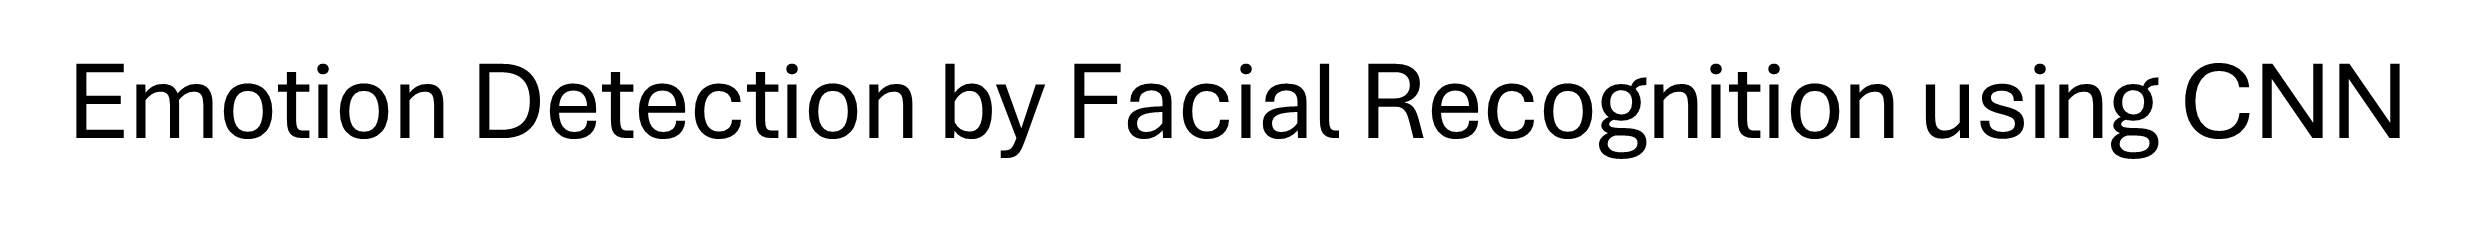

###  **Author:** Meet Vora, Saurabh Verma, Tushar Chotlani, Vinesh Sangoi <br>

**Description:** Training an image classifier from scratch on the FER-2013 Dataset.

# Data Set

Data Source: [Facial Expression Recognition 2013 Dataset] (https://paperswithcode.com/dataset/fer2013)

Data Collector: Pierre-Luc Carrier, Aaron Courville

Reference Paper: [Facial Expression Recognition with Deep Learning]
(https://cs230.stanford.edu/projects_winter_2020/reports/32610274.pdf)

**Description of the Data:**

The dataset comprises grayscale images of faces, each sized 48x48 pixels. These images are standardized to ensure consistent centering and spacing of the face within each image. The objective is to classify each face into one of seven emotion categories:

Angry (0)

Disgust (1)

Fear (2) 

Happy (3)

Sad (4) 

Surprise (5)

Neutral (6)

"train.csv" contains two columns: "emotion," ranging from 0 to 6, representing the depicted emotion, and "pixels," containing space-separated pixel values in row-major order. "test.csv" includes only the "pixels" column for prediction. The training set comprises 28,709 examples, while both the public and final test sets consist of 3,589 examples each. The target variable for our problem will be “emotions” column.


# Installing Packages 

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import keras
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Importing data and setting up directory to save model data

In [5]:
os.makedirs('test_dir', exist_ok=True)

In [6]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


# Data Cleaning

In [7]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Data Analysis

In [8]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


        sad  fear  angry  neutral  surprise  disgust  happy
train  4830  4097   3995     4965      3171      436   7215
       sad  fear  angry  neutral  surprise  disgust  happy
test  1247  1024    958     1233       831      111   1774


<Axes: >

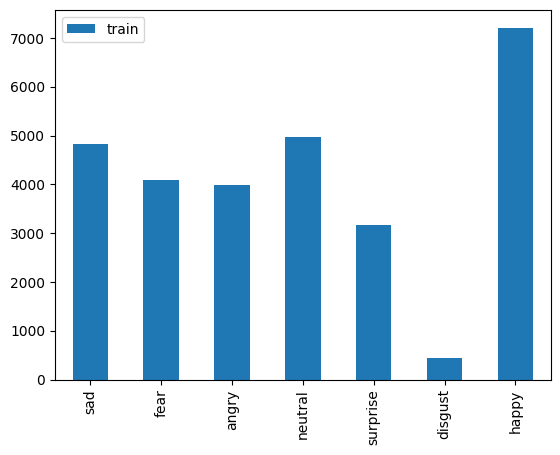

In [9]:
train_count.transpose().plot(kind='bar')

<Axes: >

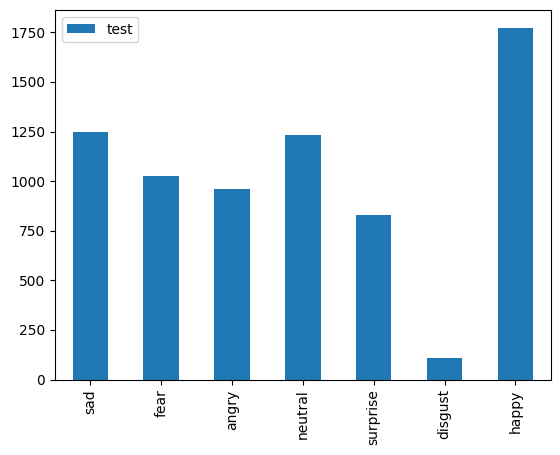

In [10]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion.

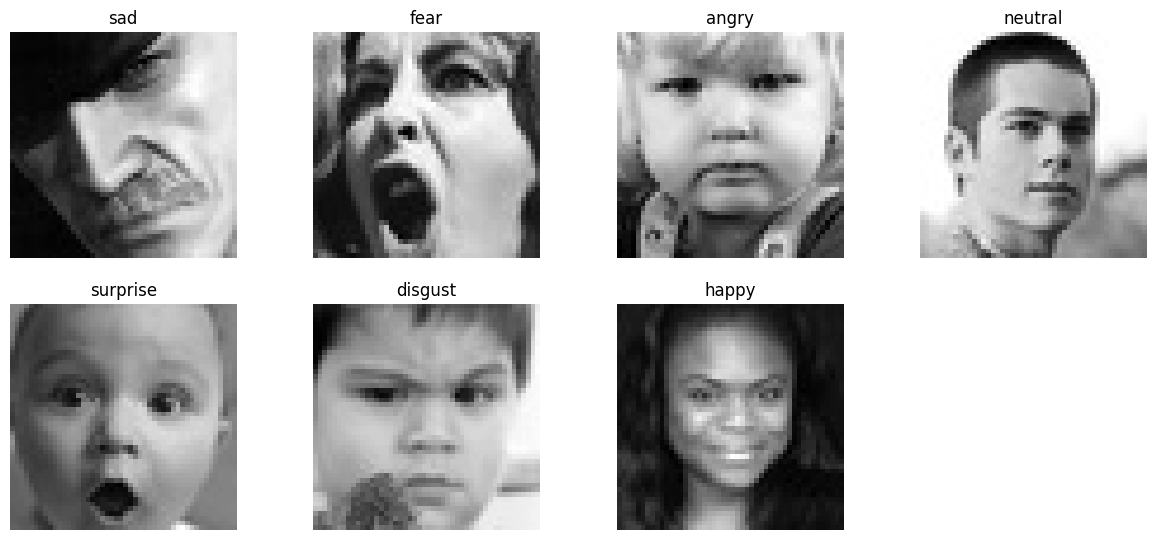

In [11]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# Plotting random images from given directory

In [12]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

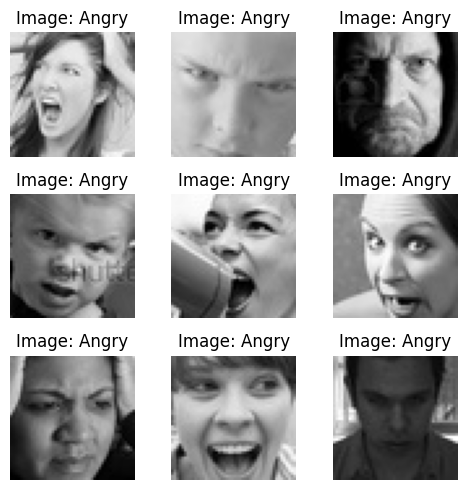

In [13]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

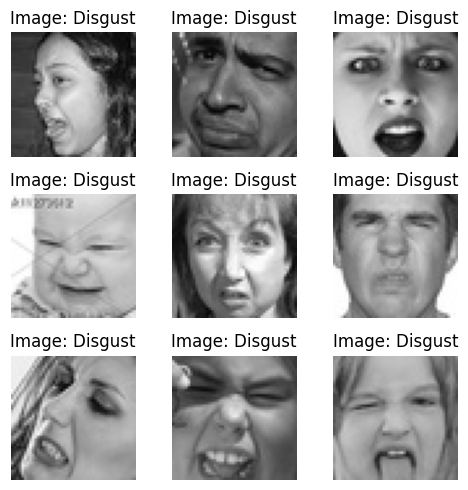

In [14]:
# Placeholder for the directory path
disgust_directory_path = '/content/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

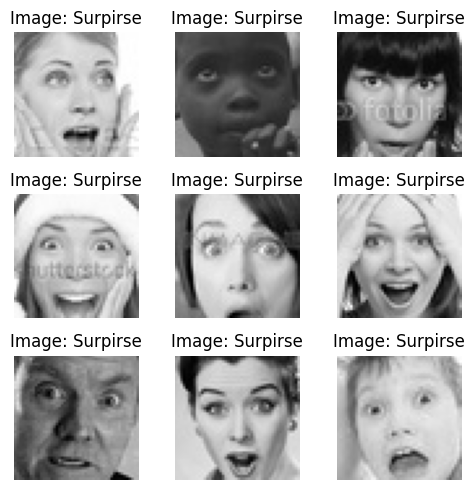

In [15]:
# Placeholder for the directory path
surpirse_directory_path = '/content/train/surprise'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

# Checking shapes and channels

In [16]:
image = '/content/train/angry/Training_10118481.jpg'

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [17]:
image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Model 1 : Custom CNN from Scratch

**This model comprises of successive convolutional layers, each equipped with rectified linear unit (ReLU) activation functions to introduce non-linearity. Batch normalization is employed to stabilize and accelerate training, while dropout layers are strategically inserted to combat overfitting. Max pooling layers systematically downsample feature maps, preserving essential information. L2 regularization is selectively applied to convolutional and dense layers to prevent excessive parameter magnitudes. The network culminates in dense layers for high-level feature processing and classification. By fostering feature hierarchies and regularization, this model excels in discerning complex patterns within images, ensuring robust classification accuracy.**

## Initializing the ImageGenerators

In [18]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [19]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

In [20]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [21]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [22]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [24]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

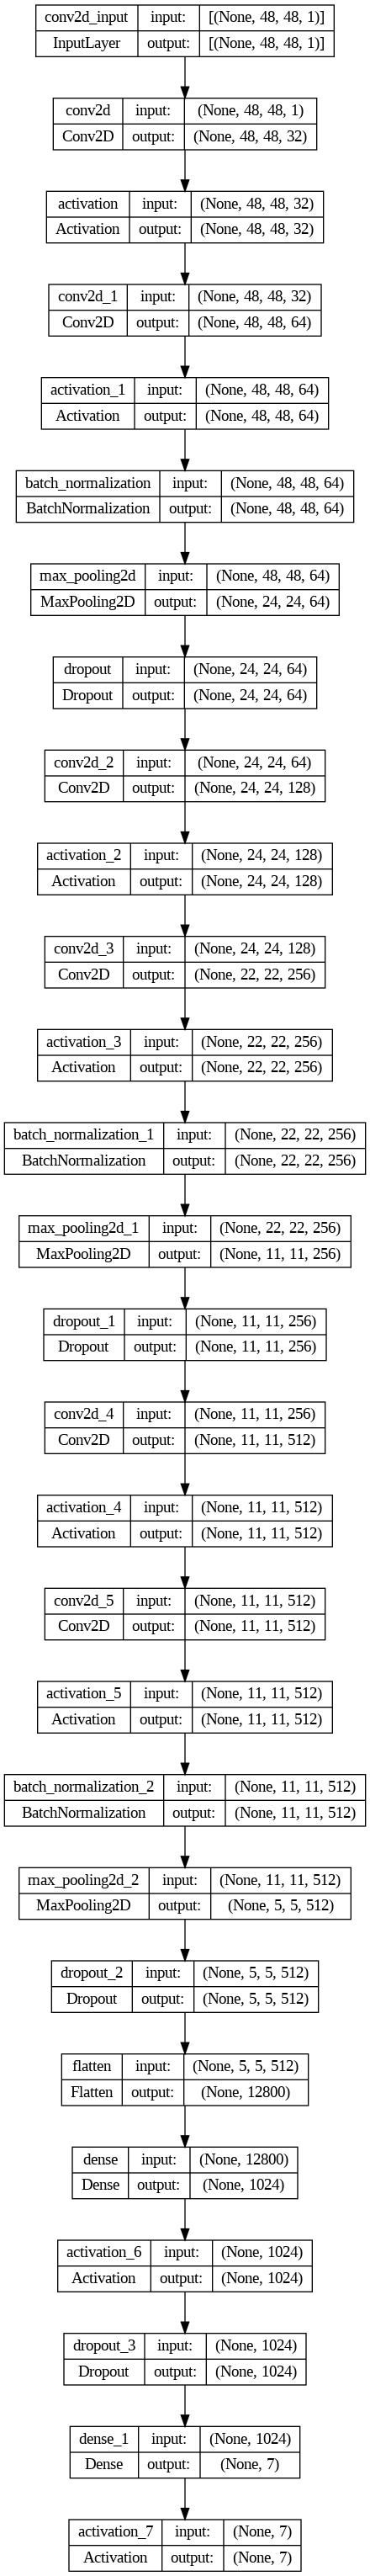

In [26]:
plot_model(model, to_file = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

# Understanding Callbacks

In [27]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [28]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [29]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [30]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [31]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [32]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

# Calculating steps for epoch

In [33]:
train_generator.samples

22968

In [34]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# Model Training

In [35]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.3919 - accuracy: 0.2808
Epoch 1: val_loss improved from inf to 12.84613, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 38s 77ms/step - loss: 12.3919 - accuracy: 0.2808 - val_loss: 12.8461 - val_accuracy: 0.2221 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.1646 - accuracy: 0.3530
Epoch 2: val_loss improved from 12.84613 to 9.55882, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 24s 68ms/step - loss: 10.1646 - accuracy: 0.3530 - val_loss: 9.5588 - val_accuracy: 0.3961 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.1198 - accuracy: 0.4001
Epoch 3: val_loss improved from 9.55882 to 7.24789, saving model to /content/FER_2013_Emotion_Detection/Cus

# Plotting Performance Metrics

In [36]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

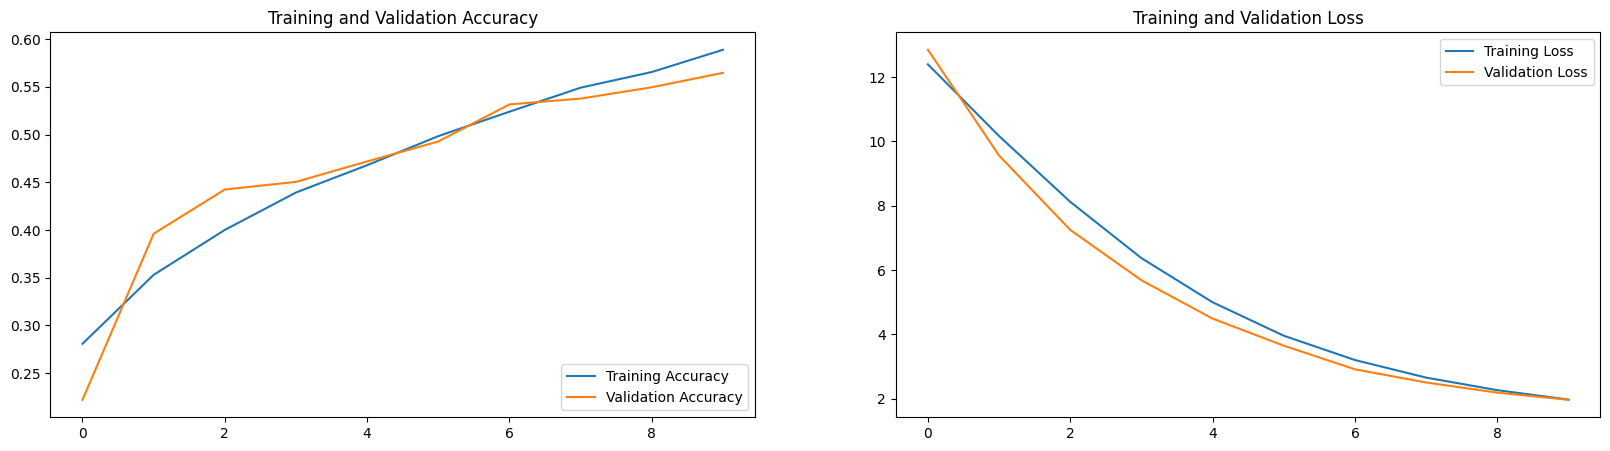

In [37]:
plot_training_history(history)

# Model Evaluation

In [38]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 25ms/step - loss: 1.9572 - accuracy: 0.5660
final train accuracy = 65.20 , validation accuracy = 56.60


# Making Predictions

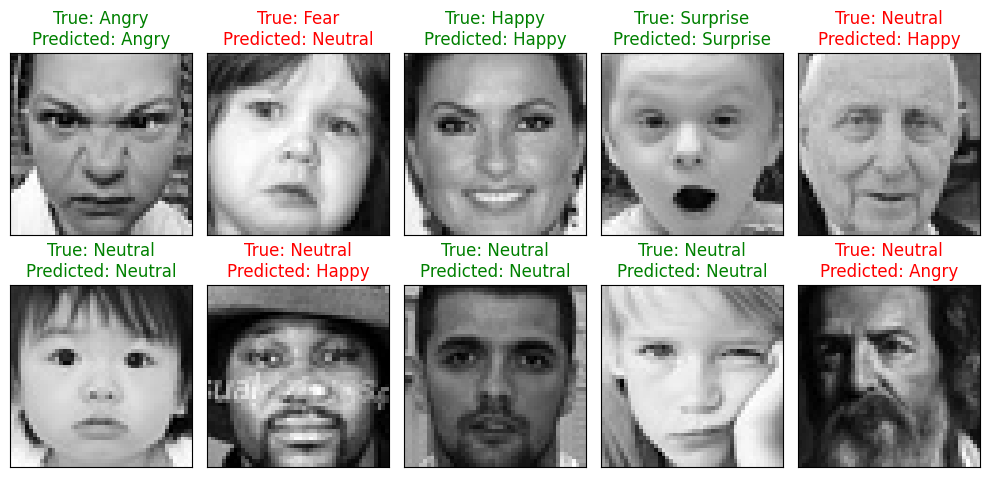

In [41]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2: Image Augmentation

**This model implements a Convolutional Neural Network (CNN) by employing image augmentation to enhance model generalization. It defines data paths, sets image dimensions, and initializes augmentation parameters. The CNN architecture comprises convolutional layers, batch normalization, max-pooling, dropout, and dense layers for classification. The model is compiled with appropriate optimizer and loss function, and callbacks are defined for model checkpointing and early stopping. Training is conducted with training and validation data generators, and the model's performance is evaluated. Through this pipeline, the code aims to build a robust CNN model for accurate emotion classification, leveraging image augmentation techniques.**

In [42]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


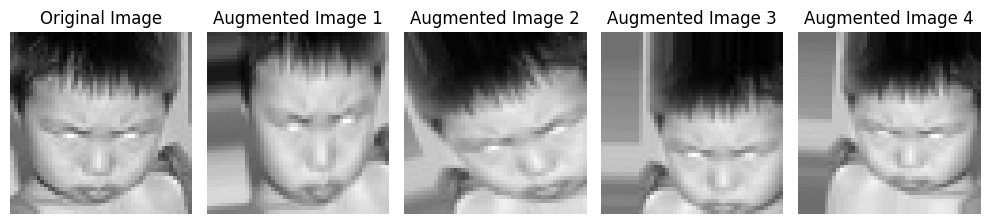

In [43]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch
    # save image
    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Same CNN Model as above

In [44]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 12.4937 - accuracy: 0.2229
Epoch 1: val_loss improved from inf to 12.81644, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 32s 82ms/step - loss: 12.4937 - accuracy: 0.2229 - val_loss: 12.8164 - val_accuracy: 0.1763 - lr: 1.0000e-04
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 10.2992 - accuracy: 0.2377
Epoch 2: val_loss improved from 12.81644 to 9.85215, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 29s 81ms/step - loss: 10.2992 - accuracy: 0.2377 - val_loss: 9.8521 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 8.2257 - accuracy: 0.2433
Epoch 3: val_loss improved from 9.85215 to 7.65702, saving model to /conte

# Plotting Performance Metrics

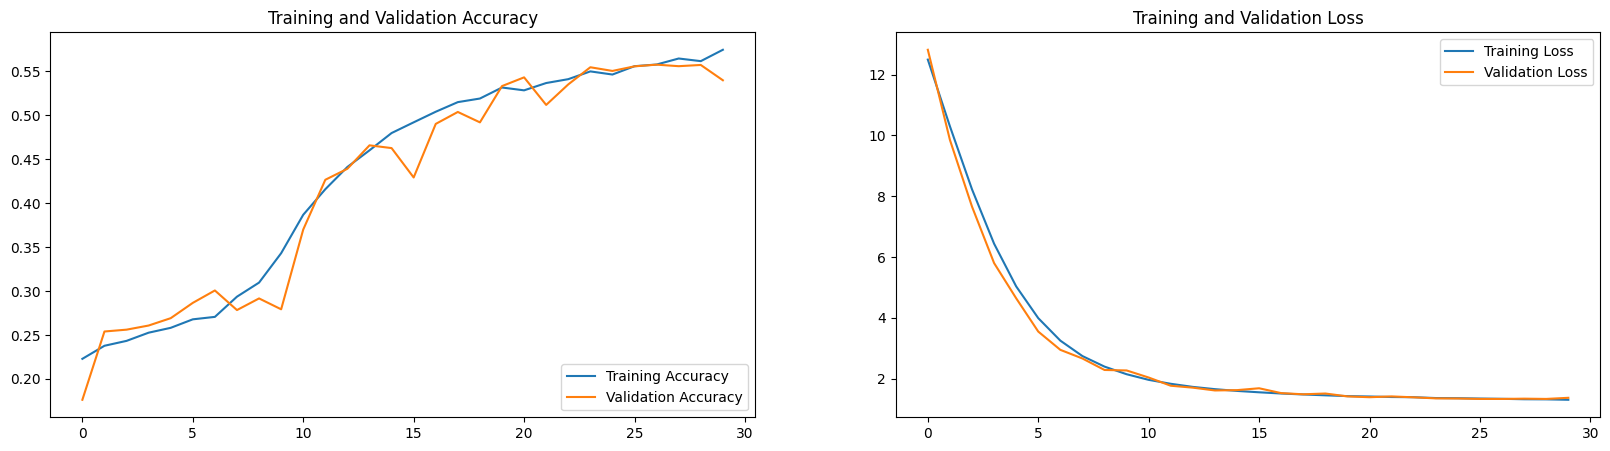

In [45]:
plot_training_history(history)

# Model Evaluation

In [46]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 22ms/step - loss: 1.2599 - accuracy: 0.5787
final train accuracy = 57.21 , validation accuracy = 57.87


# Model 3: Transfer Learning VGGNET

**This Model implements a transfer learning approach using the VGG16 model for emotion detection. It starts by defining paths to the training and testing directories, along with various parameters like image dimensions, batch size, and number of classes. Image data generators are set up for data augmentation and preprocessing. The VGG16 model is loaded with pre-trained ImageNet weights, and its top layers are made non-trainable. Custom dense layers are added on top of the VGG16 base, followed by compilation with an Adam optimizer.**

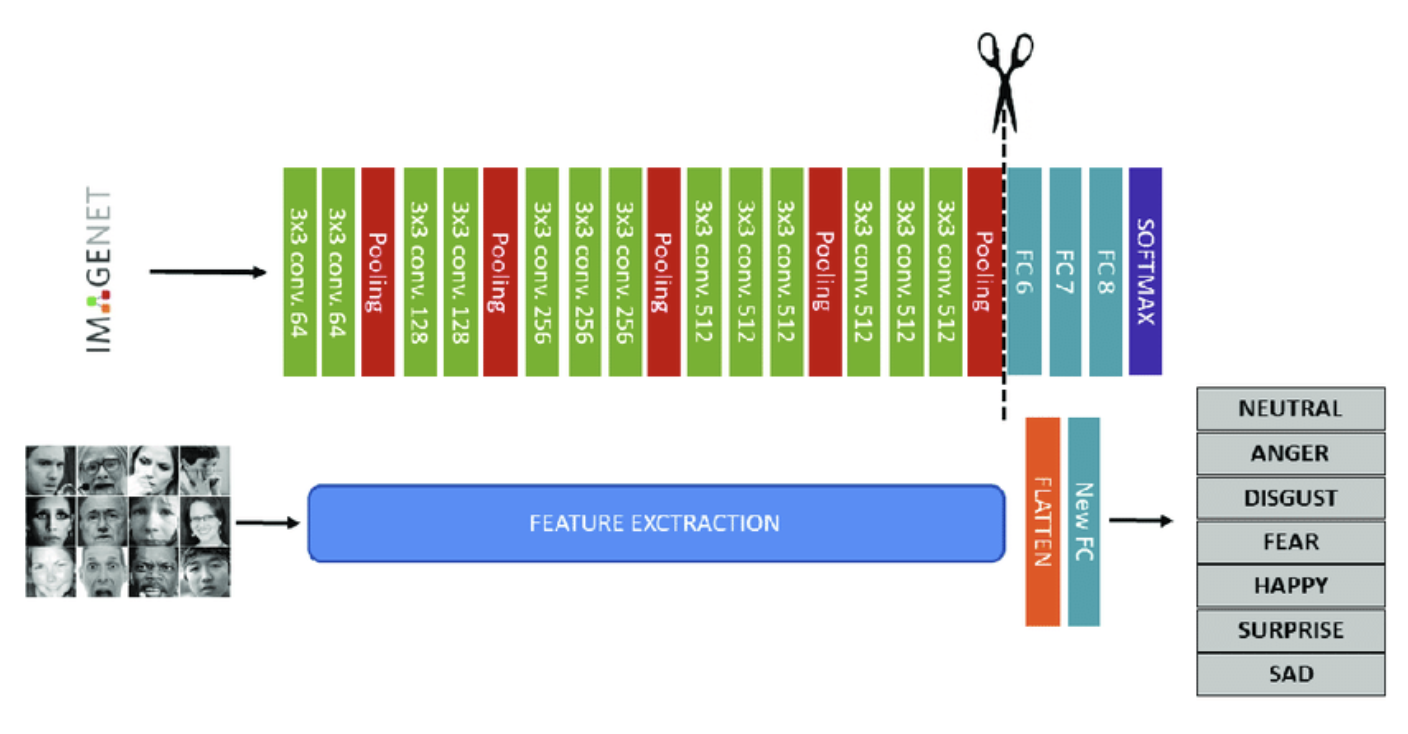

In [49]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [50]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [51]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [52]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [53]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [54]:
classes

7

In [55]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [56]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# Model Training

In [57]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.7915 - accuracy: 0.3018
Epoch 1: val_loss improved from inf to 1.51497, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 425s 915ms/step - loss: 1.7915 - accuracy: 0.3018 - val_loss: 1.5150 - val_accuracy: 0.4352 - lr: 1.0000e-04
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 1.5574 - accuracy: 0.4034
Epoch 2: val_loss improved from 1.51497 to 1.43449, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 401s 894ms/step - loss: 1.5574 - accuracy: 0.4034 - val_loss: 1.4345 - val_accuracy: 0.4576 - lr: 1.0000e-04
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 1.4492 - accuracy: 0.4448
Epoch 3: val_loss improved from 1.43449 to 1.35083, saving model to /content/FER_2013_Emotion_De

# Plotting Performance Metrics

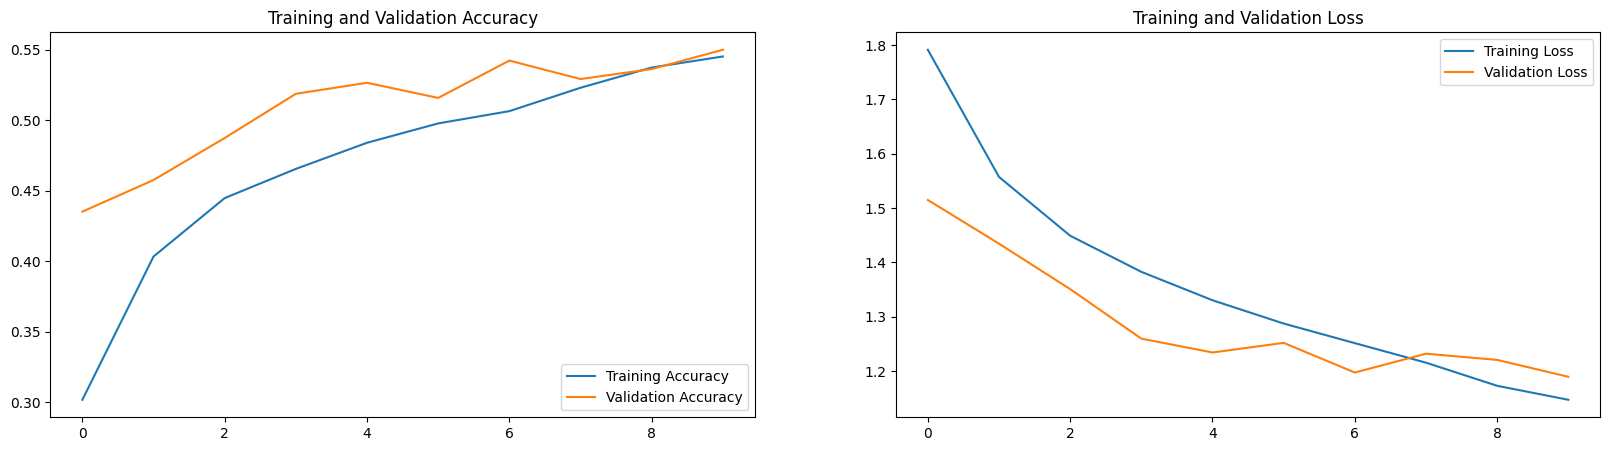

In [58]:
plot_training_history(history)

# Model Evaluation

In [59]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 28s 242ms/step - loss: 1.1895 - accuracy: 0.5500
final train accuracy = 55.42 , validation accuracy = 55.00


# Model 4 : Transfer Learning - ResNet50

**This model implements transfer learning with ResNet50V2 . It prepares data, computes class weights, and constructs a model with fine-tuning. Training includes callbacks for model checkpointing, early stopping, and learning rate reduction. After training, the model is evaluated on both training and test sets, and its accuracy is reported.  Overall, it showcases a comprehensive approach to building, training, and evaluating a deep learning model for image classification tasks, effectively addressing issues like class imbalance and model optimization.**

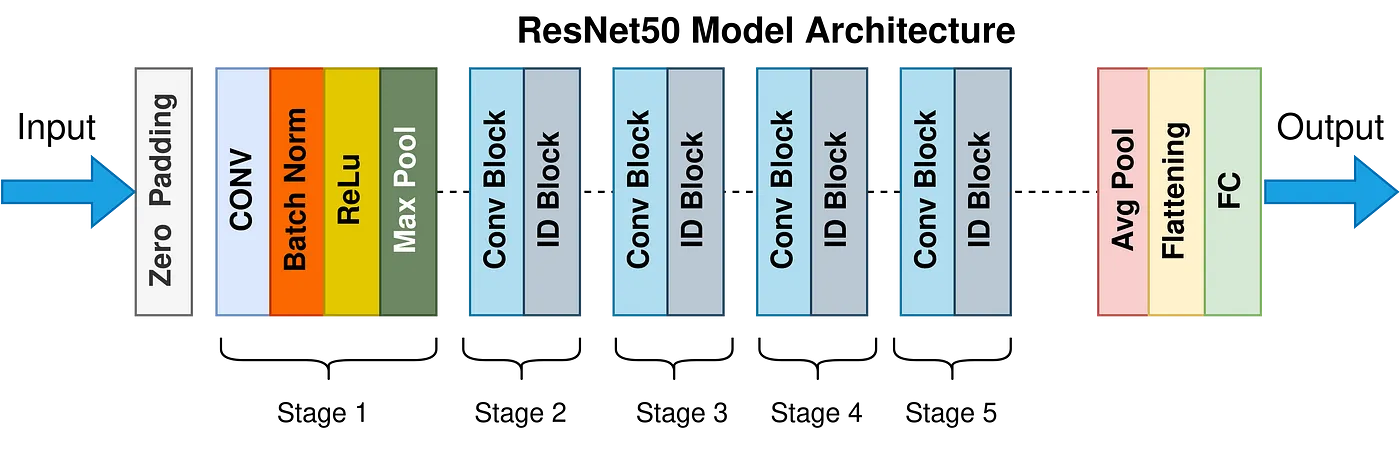

In [18]:
# Directory paths for training and testing data
train_dir = '/content/train'
test_dir = '/content/test'

# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Introducing Class wieghts for imbalanced data

In [19]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [20]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 0s 0us/step


In [21]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [22]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [23]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# Model Training

In [26]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=10,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.7187 - accuracy: 0.3865
Epoch 1: val_loss improved from inf to 1.55361, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 414s 880ms/step - loss: 1.7187 - accuracy: 0.3865 - val_loss: 1.5536 - val_accuracy: 0.4040
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 1.4201 - accuracy: 0.4807
Epoch 2: val_loss did not improve from 1.55361
449/449 [==============================] - 400s 890ms/step - loss: 1.4201 - accuracy: 0.4807 - val_loss: 43.6755 - val_accuracy: 0.2237
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 1.4059 - accuracy: 0.5025
Epoch 3: val_loss improved from 1.55361 to 1.23449, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 395s 880ms/step - loss: 1.4

In [27]:
model.save("Test_model.keras")

# Plotting Performance Metrics

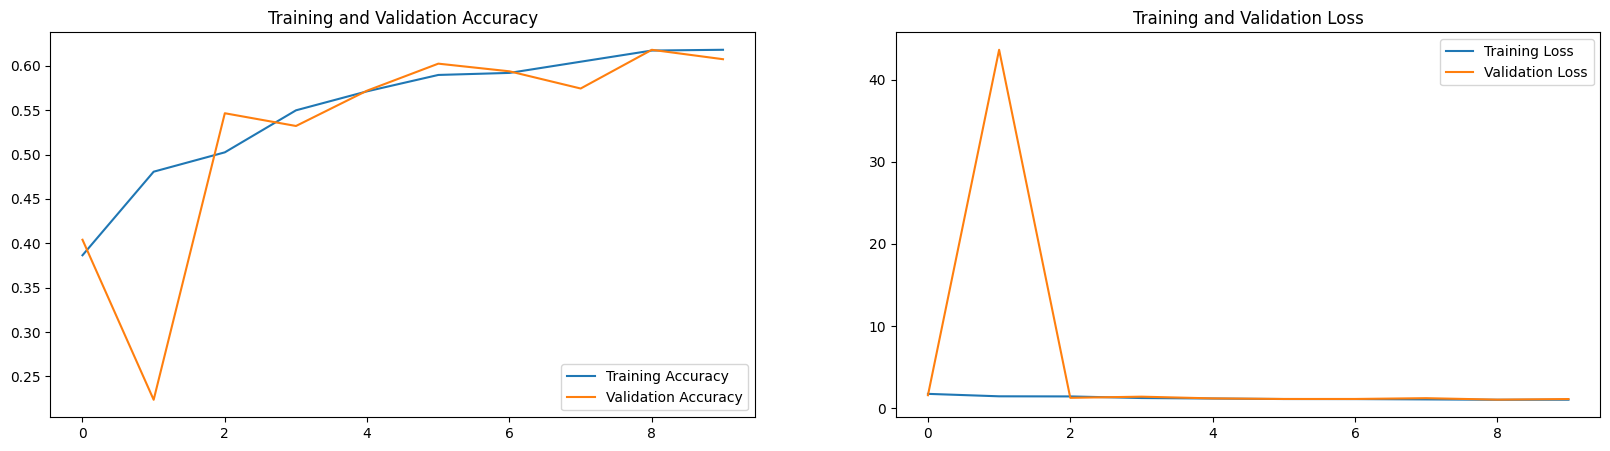

In [30]:
plot_training_history(train_history)

In [34]:
saurabh = keras.saving.load_model('/content/Test_model.keras')

In [35]:
train_history = saurabh.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=5,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/5
449/449 [==============================] - ETA: 0s - loss: 0.9748 - accuracy: 0.6292
Epoch 1: val_loss did not improve from 1.01304
449/449 [==============================] - 409s 885ms/step - loss: 0.9748 - accuracy: 0.6292 - val_loss: 1.0576 - val_accuracy: 0.6187
Epoch 2/5
449/449 [==============================] - ETA: 0s - loss: 0.9462 - accuracy: 0.6389
Epoch 2: val_loss improved from 1.01304 to 0.97126, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 400s 890ms/step - loss: 0.9462 - accuracy: 0.6389 - val_loss: 0.9713 - val_accuracy: 0.6434
Epoch 3/5
449/449 [==============================] - ETA: 0s - loss: 0.9383 - accuracy: 0.6391
Epoch 3: val_loss did not improve from 0.97126
449/449 [==============================] - 405s 901ms/step - loss: 0.9383 - accuracy: 0.6391 - val_loss: 0.9786 - val_accuracy: 0.6311
Epoch 4/5
449/449 [==============================] -

In [36]:
test_loss, test_accu = saurabh.evaluate(test_generator)
print(test_loss, test_accu)

113/113 [==============================] - 21s 183ms/step - loss: 1.0060 - accuracy: 0.6382
1.0060391426086426 0.638200044631958


# Model Evaluation

In [38]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 20s 177ms/step - loss: 1.0862 - accuracy: 0.6074
final train accuracy = 61.86 , validation accuracy = 60.74


# Plotting Confusion Matrix

113/113 [==============================] - 21s 182ms/step


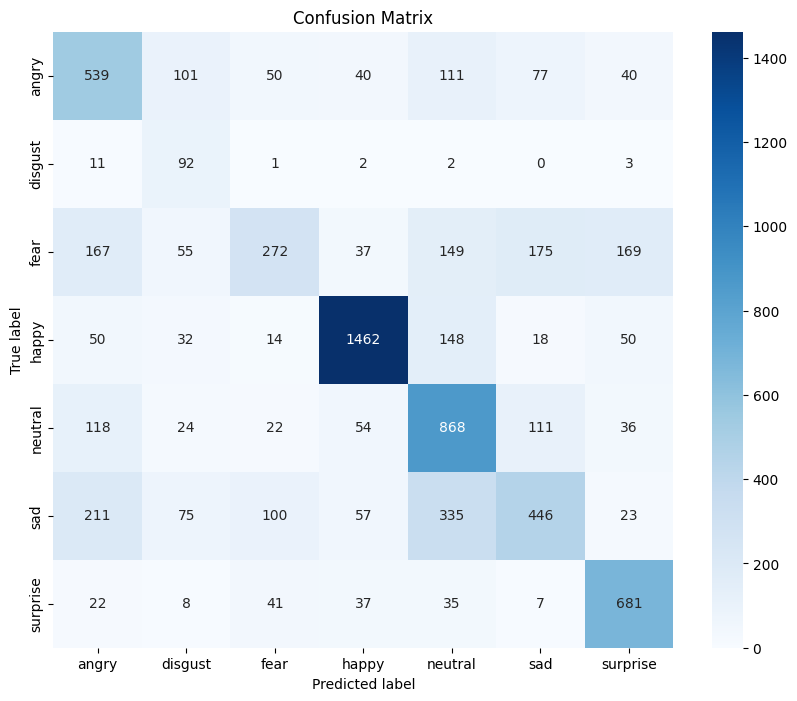

In [39]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.48      0.56      0.52       958
     disgust       0.24      0.83      0.37       111
        fear       0.54      0.27      0.36      1024
       happy       0.87      0.82      0.84      1774
     neutral       0.53      0.70      0.60      1233
         sad       0.53      0.36      0.43      1247
    surprise       0.68      0.82      0.74       831

    accuracy                           0.61      7178
   macro avg       0.55      0.62      0.55      7178
weighted avg       0.62      0.61      0.60      7178



# AUC ROC plot for each class

In [41]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

113/113 [==============================] - 20s 173ms/step


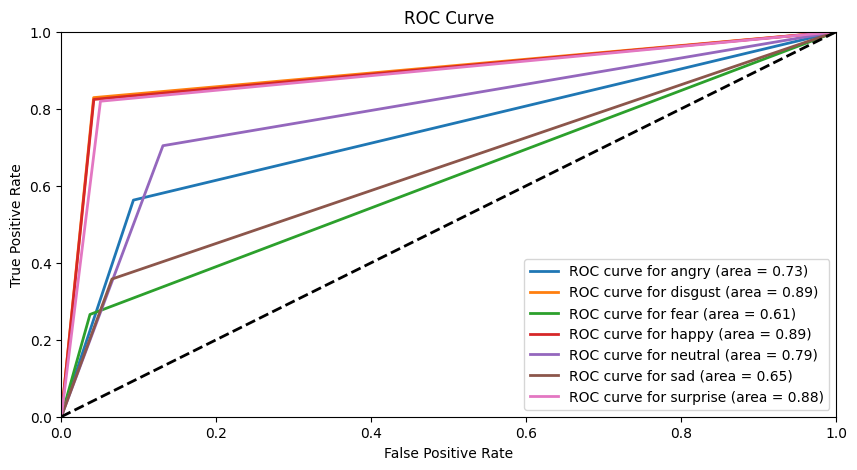

In [42]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [43]:
model.save("Resnet_model_version_2.keras")

# Discussion:

### Model 1: Custom CNN from Scratch

#### Pros:

Provides flexibility in designing the architecture tailored specifically for the task at hand.
Allows complete control over all aspects of the model, including layer configurations, activation functions, and regularization techniques.
Can potentially capture task-specific features more effectively by learning from scratch.

#### Cons:

Requires a larger dataset and longer training time compared to transfer learning approaches.
Prone to overfitting, especially when dealing with limited training data.
May struggle to generalize well to unseen data, especially if the dataset is small or lacks diversity.

### Model 2: Image Augmentation

#### Pros:

Enhances the model's robustness and generalization by artificially increasing the diversity of the training data.
Helps prevent overfitting by exposing the model to a wider range of variations in the input data.
Can lead to improved performance, especially when dealing with limited training data.

#### Cons:

Augmentation increases computational overhead during training, as each batch of data needs to be augmented on-the-fly.
Requires careful selection of augmentation techniques and parameters to avoid introducing unrealistic variations in the data.
May not completely eliminate overfitting, especially if the model architecture is complex or the dataset is highly imbalanced.

### Model 3: Transfer Learning VGGNET

#### Pros:

Leverages pre-trained models that have been trained on large-scale datasets like ImageNet, capturing generic features that are useful for a wide range of tasks.
Allows for faster convergence and better generalization, especially when dealing with limited training data.
Reduces the need for extensive computational resources compared to training a model from scratch.

#### Cons:
The choice of pre-trained model may not always be optimal for the target task, potentially limiting performance.
Fine-tuning the pre-trained model requires careful selection of hyperparameters and may lead to overfitting if not done properly.
Transfer learning may not be suitable for tasks that require task-specific features that are not well-represented in the pre-trained model.

### Model 4: Transfer Learning - ResNet50

#### Pros:

Utilizes a state-of-the-art architecture (ResNet50V2) known for its effectiveness in deep learning tasks.
Offers improved generalization and faster convergence compared to training a model from scratch.
Provides a good balance between computational resources and performance, making it suitable for a wide range of tasks.

#### Cons:
Fine-tuning the top layers of the pre-trained model requires careful adjustment of hyperparameters to prevent overfitting.
The choice of pre-trained model may not always be optimal for the specific task, necessitating experimentation and validation on the target dataset.
Transfer learning approaches may not fully exploit the unique characteristics of the target dataset, potentially limiting performance in certain scenarios.

### Overall Considerations:

Dataset Size and Diversity: The size and diversity of the dataset play a crucial role in determining the most suitable approach. Larger and more diverse datasets may benefit from training a custom CNN from scratch, while smaller datasets may benefit from transfer learning or augmentation.

### Computational Resources: 

Available computational resources, including hardware and time constraints, influence the choice of approach. Transfer learning generally requires fewer computational resources compared to training from scratch.

### Performance Requirements: 

The desired performance level and the importance of generalization to unseen data guide the selection of the model. Transfer learning models tend to offer better performance in terms of convergence speed and generalization, especially when pre-trained models are well-suited for the task.

In practice, it's often beneficial to experiment with multiple approaches and evaluate them on validation data to determine the best-performing model for a given task and dataset. Additionally, ensembling multiple models or combining different approaches may further enhance performance and robustness.

# Results:

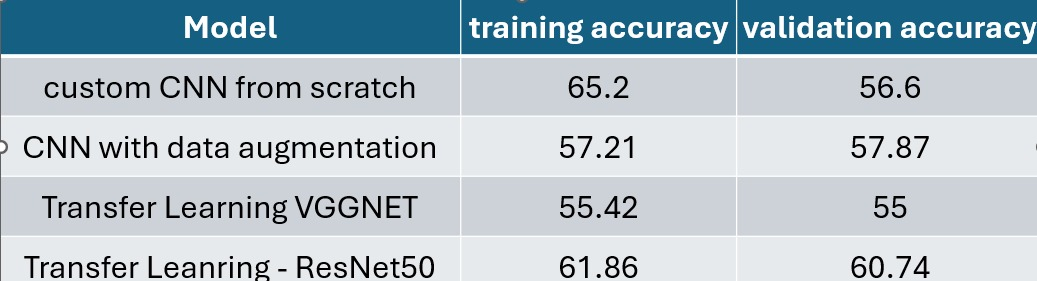

# Conclusion:

In conclusion, the choice of the most appropriate approach for emotion detection using facial expressions depends on several factors including dataset size, computational resources, performance requirements, and desired generalization capabilities. Here's a summarized conclusion based on the discussion:

#### Custom CNN from Scratch:
    
Provides flexibility in architecture design but requires a large dataset and longer training time.
May overfit if not properly regularized, especially with limited data.
Suitable for tasks where task-specific features are crucial and ample data is available for training.

#### Image Augmentation:

Enhances model robustness and generalization by artificially increasing dataset diversity.
Adds computational overhead during training but can mitigate overfitting and improve performance.
Effective for improving model performance, especially with limited data, but requires careful parameter tuning.

#### Transfer Learning (VGGNET and ResNet50):

Utilizes pre-trained models to leverage knowledge from large-scale datasets like ImageNet.
Offers faster convergence, better generalization, and reduced computational requirements compared to training from scratch.
Requires careful fine-tuning of hyperparameters and model architecture to prevent overfitting.
Well-suited for tasks where generic features are relevant and sufficient training data may be limited.

Overall, transfer learning approaches, such as VGGNET and ResNet50, offer a good balance between performance and computational efficiency, making them well-suited for many emotion detection tasks, particularly when dataset sizes are limited. However, custom CNNs from scratch and image augmentation can also be effective, especially in scenarios where task-specific features are crucial or additional data augmentation is necessary to improve model robustness. Experimentation and validation on the target dataset are key to selecting the most suitable approach for a given task.






